In [1]:
import os

import keras
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt



In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


2022-07-03 06:55:58.500893: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-03 06:55:58.520828: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-03 06:55:58.520877: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (175810b935cb): /proc/driver/nvidia/version does not exist


(1, 5, 9, 3) float64 0.999861039755275 9.763738104795472e-06


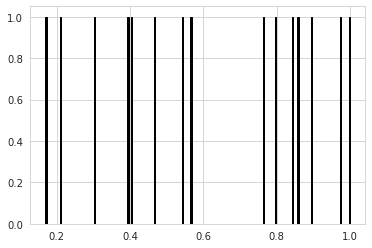

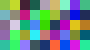

In [3]:
shape = (1,5,9,3)
dummy = np.random.random(shape)
#dummy = np.ones(shape).astype(np.float32)

if 0:
    dummy[0,0,0,:] = [1,0,0]
    dummy[0,0,1,:] = [0,1,0]
    dummy[0,0,2,:] = [0,0,1]

    dummy[0,1,0,:] = [.5,0.,0.]
    dummy[0,1,1,:] = [0.,.5,0.]
    dummy[0,1,2,:] = [0.,0.,.5]
    dummy[0,1,3,:] = [0.,0.,0]

    dummy[0,2,0,:] = [.01,.01,.01]
    dummy[0,2,1,:] = [.1,.1,.1]
    dummy[0,2,2,:] = [.2,.2,.2]
    dummy[0,2,3,:] = [.5,.5,.5]

    dummy[0,3,0,:] = [1,1,0]
    dummy[0,3,1,:] = [0,1,1]
    dummy[0,3,2,:] = [1,0,1]
    dummy[0,3,3,:] = [.5,.5,.5]


print(dummy.shape,dummy.dtype,dummy.max(),dummy.min())

plt.hist(dummy[:,:,1].flatten(), bins=256,  fc='k', ec='k')
plt.show()

image = tf.keras.utils.array_to_img(dummy[0]*255,scale=False,dtype = np.float32,data_format='channels_last')

image = image.resize((image.width*10,image.height*10),0)
image.show()
k_size = (2,2)

def get_pass_through_conv(input_shape,k_size,strides=(1,1),padding='valid'):
    myconv = tf.keras.layers.Conv2DTranspose(filters=3,
                                            kernel_size=k_size,
                                            strides=strides,
                                            padding=padding)

    #return myconv
    myconv.build(input_shape)
    #myconv(np.ones(input_shape))
    #current_w, current_bias = myconv.get_weights()  # see the current weights
    #print(f'cws',current_w.shape)

    #new_w = tf.constant((np.random.random(current_w.shape)-.5)*2,dtype=tf.float32)
    #new_w = tf.constant((np.random.random(current_w.shape)),dtype=tf.float32)
    #new_w = tf.constant([[[1.0]*3,[.8]*3],[[.6]*3,[.4]*3]])
    #new_w = tf.constant(np.ones(current_w.shape))

    #new_w = tf.reshape(new_w, current_w.shape)  # fix the shape
    #new_bias = tf.constant(np.ones(current_bias.shape))  # fix the shape
    #myconv.set_weights([new_w, new_bias])
    return myconv

out_im=[]
out_np=[]
def hist_loss(x,y):
    h= tf.histogram_fixed_width(y,nbins=256,value_range=(0,1))
    h=tf.cast(h,tf.float32)
    d = tf.subtract(h,tf.reduce_mean(h))
    d= tf.cumsum(d,axis=0)
    d=tf.pow(d,2)
    return d
def type1():
    n = tf.keras.Input(shape=(5,9,3))
    m = get_pass_through_conv(input_shape=dummy.shape,k_size=2,strides=1)(n)
    m = tf.keras.layers.Activation('tanh')(m)
    print (m.shape)

    m = get_pass_through_conv(input_shape=dummy.shape,k_size=2,strides=2)(m)
    m = tf.keras.layers.Activation('tanh')(m)
    print (m.shape)

    m = get_pass_through_conv(input_shape=dummy.shape,k_size=2,strides=2)(m)
    m = tf.keras.layers.Activation('tanh')(m)
    print (m.shape)

    m = get_pass_through_conv(input_shape=dummy.shape,k_size=2,strides=2)(m)
    m = tf.keras.layers.Activation('tanh')(m)
    print (m.shape)

    m = get_pass_through_conv(input_shape=dummy.shape,k_size=5,strides=3)(m)
    m = tf.keras.layers.Activation('sigmoid')(m)

    print (m.shape)


    return n,m

In [4]:

n,m = type1()
m=tf.keras.layers.Flatten()(m)
m=tf.keras.layers.Lambda(lambda x: tf.cast( tf.histogram_fixed_width(x,value_range=(0,1),nbins=256),np.float32))(m)
mdl=tf.keras.models.Model(inputs=n,outputs=m)
mdl.compile(optimizer='adam',loss='mse')
print('mis:',mdl.input_shape)
y = mdl(dummy)
print('model output shape: ',y.numpy().shape)
print(y.numpy().max())
print(y.numpy().min())
print(y.numpy().mean())
print(y.numpy().sum()/256)
#plt.hist(y[:,:,2].numpy().flatten(), bins=256,  fc='k', ec='k')

#im = tf.keras.preprocessing.image.array_to_img(y[0],scale=True)
#X=np.random.random((100,)+y[0].numpy().shape)
y=np.ones((100,256))*414.0
print(y.shape)
print(y.dtype)
#im.show()
#tf.keras.preprocessing.image.array_to_img(X[0],scale=True).show()

(None, 6, 10, 3)
(None, 12, 20, 3)
(None, 24, 40, 3)
(None, 48, 80, 3)
(None, 146, 242, 3)
mis: (None, 5, 9, 3)
model output shape:  (256,)
45133.0
0.0
414.04688
414.046875
(100, 256)
float64


In [11]:
!pip install pydot
!pip install graphviz
from keras.utils import vis_utils
from IPython.display import SVG
SVG(vis_utils.model_to_dot(mdl, show_shapes=True).create_svg())



('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'NoneType' object has no attribute 'create_svg'

In [ ]:
mdl.fit(np.random.random(size=(100,5,9,3)),y,epochs=1)